# Randomness and Random Walks

## Learning Objectives

By the end of this chapter, you will be able to:

1. Understand what pseudorandom numbers are and why seeding/reproducibility matters.
    
2. Generate uniform random variates and map them to arbitrary intervals.
	
3. Use inverse-transform sampling to draw from a specified 1D distribution and validate with a histogram.

4. Explain and test random-walk scaling ($R_\mathrm{rms}\propto \sqrt{N}$).
	
5. Implement a simple Python class and use it to run/analyze a random-walk simulation.

## Deterministic Randomness 

Some people are attracted to computing because of its deterministic nature. Nevertheless, many computer cycles are used for **Monte Carlo calculations**. 

Monte Carlo calculations include elements of chance at their very core (hence the name). They involve *random-like* numbers generated by a computer to simulate naturally-random processes, such as thermal motion or radioactive decay. 

Monte Carlo techniques are able to solve very challenging problems!

## Random Sequences 

We define a sequence $r_1, r_2,...$ as random if there are no correlations between the coefficients. 

But: being random does not mean all numbers in the sequence are equally likely to occur! 

If all numbers in a sequence are equally likely to occur: the sequence is called **uniform**. 

Mathematically: the likelihood of a number occurring is described by a distribution $P(r)$, where $P(r)\mathrm{d}r$ is the probability of finding $r$ in the interval $[r, r+\mathrm{d}r]$. 

For a **uniform distribution**: $P(r) = \mathrm{constant}$. 

The standard random number generator on computers generates *uniform* distributions between 0 and 1, i.e. it outputs numbers in this interval with equal probability, yet independent from the previous number. 

By their nature: computers are deterministic devices, and therefore cannot create a random sequence. Computed random number sequences must contain correlations, and therefore cannot be truly random. This implies that if we know $r_m$ and its preceding elements, then it is always possible to figure out $r_{m+1}$. For this reason, computers are said to generate **pseudorandom numbers**. 

A primitive alternative to this is to read off a table of truly random numbers, determined by  naturally-random process, such as radioactive decay, or to connect the computer to an experimental device that measures random events. 

### Random Number Generation

Sequences of pseudorandom numbers can be generated on a computer via the "linear congruent" or "power residue" method:

To generate a pseudorandom sequence of numbers $0 \leq r_i \leq M-1$ over the interval $[0, M-1]$, starting with $r_1$, to obtain the next random number $r_2$, multiply $r_1$ by a constant $a$, add another constant $c$ and keep the *remainder*. Repeat this with $r_2$ to get $r_3$ and so on. So to get $r_{i+1}$, given $r_i$: 

$r_{i+1} = \mathrm{remainder} \left( \frac{a r_i + c}{M} \right)$

The initial number, the *seed*, $r_1$ is frequently supplied by the user. 

In Python the remainder is given by the operator "%", i.e. the above equation would read: ```rnext = (a * rprevious + c)%M```. 

One can then divide the whole sequence by $M$ to get numbers in the interval $[0,1]$. 

If we want random numbers in an interval $[A,B]$ instead, then we can transform the generated sequence in the interval $[0,1]$, by:

$x_i = A + (B-A) r_i$

Note that the linear congruent method becomes completely correlated if a particular interger comes up a second time. The whole cycle then repeats.

If e.g. 48-bit arithmetic is used, then $M \sim 2^{48} \simeq 3\times 10^{14}$. If your program would then use approximately these many random numbers (feasible, e.g. if your program is performing Monte Carlo simulations in many dimensions!), then you may need to "re-seed" (i.e. choose a new seed) to reset the sequence during intermediate steps. 

In Python, the default ```random.random()``` algorithm is the "Mersernne Twister". It has an extremely long period: $2^{19937} -1$ (a prime number) which is approximately $4.3 \times 10^{6001}$. This is many orders of magnitude larger than the estimated number of particles in the observable universe ($\sim 10^{87}$).

See Wikipedia entry for more details, https://en.wikipedia.org/wiki/Mersenne_Twister, as well as original paper: https://dl.acm.org/doi/pdf/10.1145/272991.272995.

### Generating Random Numbers of Arbitrary Distributions

Supose we possess a random number generator that yields uniform random numbers in the interval $[0,1]$. We can use it to generate random numbers according to any distribution using the *inversion method*. 

The method proceeds as follows:

1. Suppose we want to distribute random numbers according to a function $f(x)$. We first calculate the *cumulative* distribution function (CDF) as: $F(x) = \int^x_0 \mathrm{d}x f(x)$.
2. We then find the inverse of the desired CDF, i.e. we solve $y=F(x)$ as $F^{-1}(y)=x$.
3. If then "draw" $y_0$ and calculate $x_0 = F^{-1}(y_0)$, then $x_0$ is distributed according to $f(x)$.

Here's an example for $f(x)=3x^2$ for $x \in [0,1]$. Note that $\int_0^1 \mathrm{d} x f(x)= 1$ for $f(x)$ in $[0,1]$, as expected for a probability distribution.

The CDF is $F(x) = x^3$. Then $x = y^{1/3}$ and so we have:

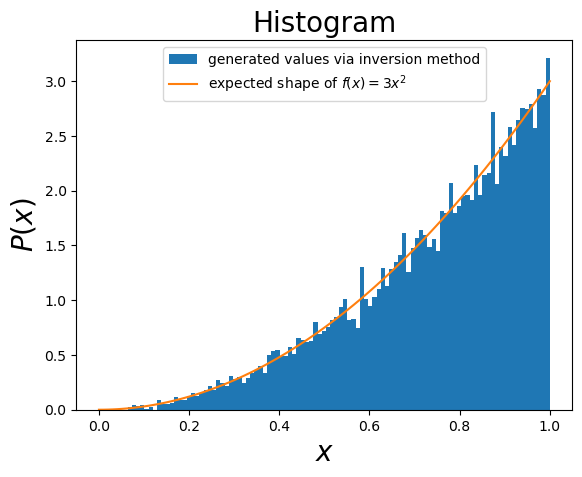

In [16]:
import random 
import math
import matplotlib.pyplot as plt # import matplotlib
import numpy as np

x = []

# We have x = (y)**(1/3) and we pick y in [0,1] 
for i in range(10000): # generate 1000 points
    y = random.random() # generate random numbers in [0,1]
    x.append( (y)**(1/3) )


# create the real distribution for comparison. Use numpy"
xcomp = np.linspace(0,1,100)
ycomp = 3*np.square(xcomp)
    
# create a histogram of x:
fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_xlabel(r'$x$', fontsize=20) # set the x label
ax.set_ylabel(r'$P(x)$', fontsize=20) # set the y label. Note that the 'r' is necessary to remove the need for double slashes. You can use LaTeX! 
ax.set_title('Histogram', fontsize=20) # set the title 

# make a histogram of the values, density=True normalizes the histogram
ax.hist(x, label='generated values via inversion method', density=True, bins=100) 

# compare to how we expect it to look like:
ax.plot(xcomp, ycomp, label='expected shape of $f(x) = 3x^2$')

# construct the legend:
ax.legend(loc='upper center')  # Add a legend

plt.show() # show the plot here

This method predicates on the existence of an analytical expression for the CDF and its inverse, and therefore is not always useful! (see later)

## Random Walks

Consider a pizza brought into this room. The molecules from its smell collide randomly with other molecules in the air and eventually reach your nose. 

The problem is to determine how many collisions, on average, a scent molecule makes in traveling a distance $R$, given that it travels an average (root-mean-square) distance $r_\mathrm{rms}$ between collisions. 

### Random Walks: Theoretical Description

A "walker" takes sequential steps with the direction of each step independent of the direction of the previous step. 

Let's consider a two-dimensional model. Start at the origin and take $N$ steps in the $xy$-plane of lengths:

$(\Delta x_1, \Delta y_1), (\Delta x_2, \Delta y_2), ..., (\Delta x_N, \Delta y_N)$

then, we have:

$R^2 = (\Delta x_1 + \Delta x_2 + ... + \Delta x_N)^2 + (\Delta y_1 + \Delta y_2 + ... + \Delta y_N)^2$.

$\Rightarrow R^2 = \Delta x_1^2 + \Delta x_2^2 + \Delta x_N^2 + 2 \Delta x_1 \Delta x_2 + 2 \Delta x_1 \Delta x_3 +  ... + (x \rightarrow y)$.

If a walk is random, then the walker is equally likely to travel in any direction at each step. If we take the average of $R^2$ over a large number of such random steops, we expect that all cross terms would vanish: 

$\left< R^2 \right> = \left< (\Delta x_1^2 + \Delta y_1^2) + (\Delta x_2^2 + \Delta y_1^2) + .. + (\Delta x_N^2 + \Delta y_N^2) \right> = N \left<r^2\right> = N r_\mathrm{rms}^2$

where $r_\mathrm{rms} = \sqrt{\left< r^2 \right>}$.

So:

$R_\mathrm{rms} = \sqrt{\left< R^2 \right>} = \sqrt{N} r_\mathrm{rms}$.

Let's investigate this theoretical description through a simulation!

Before we do so, let's introduce the concept of classes in Python (object-oriented programming), and use it in our example. 


## Digression: Object-Oriented Programming in Python

Classes provide a means of bundling data and functionality together. Creating a new class creates a new type of object, allowing new instances of that type to be made.

The simplest form of a class definition looks like:
```
class ClassName:
    <statement-1>
    .
    .
    .
    <statement-N>
```

You can read all about classes and object-oriented programming at: https://docs.python.org/3/tutorial/classes.html. Here we are going to proceed by example. 

Suppose we wish to create a new object that has the properties we expect from complex numbers. We want this object to have a real and imaginary part, and we want to easily access those, as well as perform various operations on it: e.g. get its modulus, complex conjugate or argument. 

We can begin by defining a class as follows:

In [17]:
# define a new class called Complex with real and imaginary parts (.r and .i):
class Complex:
    """A simple complex number class"""
    def __init__(self, realpart, imagpart):
        self.r = realpart
        self.i = imagpart
        print("I have created a new complex variable with r,i=", self.r, self.i)

The ```__init__()``` method is automatically invoked when you create an instance of this class:

In [8]:
# Create an "instance" of the Complex class: 
x = Complex(3.0, 4.5) # the real part is 3.0 and the imaginary part is 4.5
print('real part=', x.r)
print('imaginary part=', x.i)
y = Complex(1.0, -1.5)
print(y.r, y.i)

I have created a new complex variable with r,i= 3.0 4.5
real part= 3.0
imaginary part= 4.5
I have created a new complex variable with r,i= 1.0 -1.5
1.0 -1.5


We can also add "attribute references", i.e. functions that operate on instances of this function: 

In [10]:
import math

# define the Complex class, with mod(), arg() and cc() functions to return:
# modulus, argument and complex conjugate
# see https://en.wikipedia.org/wiki/Complex_number for details 
class Complex:
    """A more advanced complex number class"""
    def __init__(self, realpart, imagpart):
        self.r = realpart
        self.i = imagpart

    # the modulus:
    def mod(self):
        return math.sqrt(self.r**2 + self.i**2)

    # the argument 
    def arg(self):
        if self.r==0 and self.i==0:
            arg = float('nan')
        else: 
            arg = math.atan2(self.i, self.r) # this handles all cases correctly
        return arg 

    # the complex conjugate, return a Complex object with - the imaginary part
    def cc(self):
        return Complex(self.r, -self.i)

In [11]:
# Create an "instance" of the updated Complex class: 
x =Complex(3.0, 4.5) # the real part is 3.0 and the imaginary part is 4.5
print('real part=', x.r)
print('imaginary part=', x.i)

real part= 3.0
imaginary part= 4.5


In [12]:
# get the modulus:
x.mod()

5.408326913195984

In [13]:
# get the argument:
print(x.arg())

0.982793723247329


In [14]:
# get the complex conjugate, another instance of the Complex class:
y = x.cc()
print(y.r)
print(y.i)

3.0
-4.5


You can also define functions that act on two instantiations of the class. E.g. let's say we want to be able to multiply two complex numbers together correctly. 

In [11]:
import math

# define the Complex class, with mod(), arg() and cc() functions to return:
# modulus, argument and complex conjugate
# see https://en.wikipedia.org/wiki/Complex_number for details 
class Complex:
    """A more advanced complex number class"""
    def __init__(self, realpart, imagpart):
        self.r = realpart
        self.i = imagpart

    # the modulus:
    def mod(self):
        return math.sqrt(self.r**2 + self.i**2)

    # the argument 
    def arg(self):
        if self.r==0 and self.i==0:
            arg = float('nan')
        else: 
            arg = math.atan2(self.i, self.r) # this handles all cases correctly
        return arg 

    # the complex conjugate, return a Complex object with - the imaginary part
    def cc(self):
        return Complex(self.r, -self.i)

    # multiply two complex numbers together:
    def multiply(self, other):
        return Complex(self.r * other.r - self.i * other.i, self.r * other.i + self.i * other.r)

Let's try it out!

In [12]:
# define two complex numbers:
x = Complex(3.0, 4.5)
z = Complex(1.0, 2.0)
# multiply them to get another complex number
h = x.multiply(z) 
print(h.r)
print(h.i)

-6.0
10.5


(Check the answer!)

Or we can multiply x by its complex conjugate to get a real number:

In [14]:
# we can get the c.c. directly:
u = x.multiply(x.cc())
# print the real part and the imaginary parts: the latter should be zero. 
print(u.r)
print(u.i)
# the square root of the product x * x complex conjugate should the the modulus!
print(x.mod())
print(math.sqrt(u.r))

29.25
0.0
5.408326913195984
5.408326913195984


*Note that*: Python already has built-in complex numbers; we’re doing this as an exercise in object-oriented programming!

## Random-Walk Simulation

We can now proceed with a simulation of random walks. We will define a class called "walker", which will allow us to define multiple walkers and make them walk around. 

In [7]:
import random
import math 

class Walker:
    """A random walker class"""
    # instantiations of this class are initialized with an initial position
    def __init__(self, initialx, initialy):
        # initialize the x and y positions:
        self.x = initialx
        self.y = initialy
        # keep the initial positions:
        self.xinit = initialx
        self.yinit = initialy
        # keep all the positions that the walker has moved through in a list:
        self.allx = []
        self.ally = []
        self.allx.append(initialx)
        self.ally.append(initialy)

    # now let's create a function that allows us to take random steps with a certain stepsize
    def move(self, stepsize):
        deltax = (2*random.random()-1) # choose random variables in the range [-1,1]
        deltay = (2*random.random()-1)
        # normalize to stepsize:
        L = math.sqrt(deltax**2 + deltay**2)
        deltax = deltax/L
        deltay = deltay/L
        # now adjust the length
        deltax *= stepsize
        deltay *= stepsize
        # add these to the current position
        self.x = self.x + deltax
        self.y = self.y + deltay
        self.allx.append(self.x)
        self.ally.append(self.y)
    
    # get the distance from the starting position
    def distance(self):
        return math.sqrt( (self.x-self.xinit)**2 + (self.y-self.yinit)**2 )


Let's test this out with a single walker starting from (0,0): 

In [8]:
# initialize "Walker1", an instance of the class Walker
Walker1 = Walker(0,0)

# move Walker1 1000 times with stepsize 1:
for i in range(1000):
    Walker1.move(1.0)

# get the distance from the origin:
print(Walker1.distance())

29.8172773954807


Our next task is to initialize N (=9 to start with) walkers at the origin and follow their path visually! We are going to use matplotlib and evolve walkers "dynamically" on a graph.  

It also will be interesting to investigate whether our theoretical expectations agree with this simulation.

Let's also calculate, and store, the root-mean-square (rms) distance versus the of number of steps.

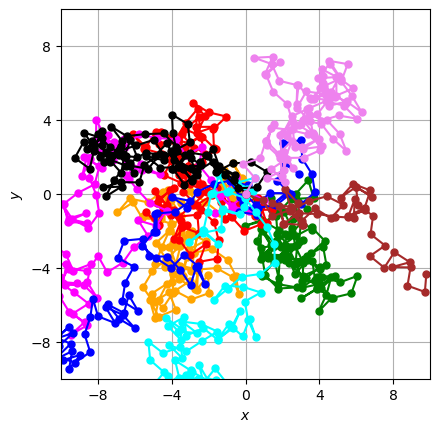

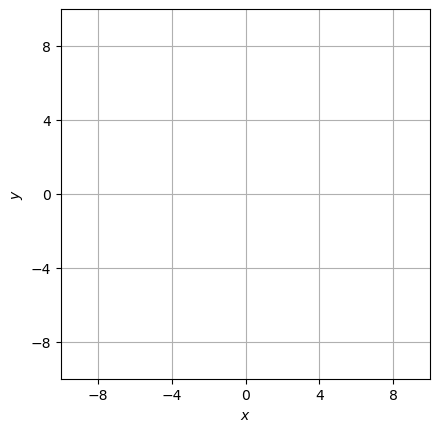

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time # various time functions
from tqdm import tqdm # progress bar
import matplotlib.ticker as ticker # 

# this allows us to access dynamic updating of the plot: 
from IPython import display
from IPython.display import clear_output

# setup the axis:
fig,ax = plt.subplots(1,1)

#get the dynamic display:
dynamicdisplay = display.display("", display_id=True)

# put a grid on the graph:
ax.grid(True, which='both')

# set the aspect ratio to 1:
ax.set_aspect(1)

# set some parameters here:
n = 9 # the number of walkers
N = 100 # the number of steps
step = 1 # the step size
Nupdate = 1 # the frequency of steps used to update the plot

# set the labels and limits:
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
limitsize = math.sqrt(N)*step
ax.set_xlim(-limitsize,limitsize)
ax.set_ylim(-limitsize,limitsize)

# set the major ticks to correspond to twice step size:
ax.xaxis.set_major_locator(ticker.MultipleLocator(4*step))
ax.yaxis.set_major_locator(ticker.MultipleLocator(4*step))

# initialize n walkers and put them in a list:
WalkerList = []
WalkerColor = [] # create a list with the colors of each walker 
colors = [ 'green', 'orange', 'red', 'magenta', 'blue', 'cyan', 'black', 'brown', 'violet'] # 9 colours
j = 0 # counter to make sure we don't go over the 9 colors
for w in range(n): 
    WalkerList.append(Walker(0,0))
    # set the color of each walker. If we w exceeds 8 then reset the counter j:
    if w-8*j > 8:
        j = j + 1
    else: 
        pass 
    WalkerColor.append(colors[w-8*j])

# now go through all the n walkers and get them to perform N steps
#for i in tqdm(range(N)): # uncomment for tqdm
for i in range(N):
    # go through all the walkers in the WalkerList
    for j, walker in enumerate(WalkerList):
        # move them one step in a random direction
        walker.move(step)

    if i%Nupdate==0: # only update every Nupdate steps
        # plot them!
        # the list will contain the points so we can remove them later:
        walkers_plot = []
        for j, walker in enumerate(WalkerList):
            walkers_plot.append(ax.plot(walker.allx, walker.ally, marker='o',color=WalkerColor[j], ls='-', markersize=5))
        dynamicdisplay.update(fig) # update the figure in the notebook
        # remove the walkers from display for next run:
        for j, walker in enumerate(WalkerList):
            wmarker = walkers_plot[j].pop(0)
            wmarker.remove()
        time.sleep(0.1) # "sleep" for half a second to allow us to see the evolution




Let's plot the RMS distance versus the square root of N! First, let's increase the number of walkers and the number of steps, without plotting:

In [6]:
import numpy as np
from tqdm import tqdm # progress bar

# set some parameters here:
n = 1000 # the number of walkers
N = 10000 # the number of steps
step = 1 # the step size
Nupdate = 1 # the frequency of steps used to update the plot

# initialize n walkers and put them in a list:
WalkerList = []
for w in range(n): 
    WalkerList.append(Walker(0,0))

# list to store R squared average (i.e. the rms) *over all the walkers* after N steps:
R_rms_list = []
# now go through all the n walkers and get them to perform N steps
#for i in tqdm(range(N)): # uncomment for tqdm
for i in range(N):
    Rsq_av = 0 # variable used to calculate the square average
    # go through all the walkers in the WalkerList
    for j, walker in enumerate(WalkerList):
        # move them one step in a random direction
        walker.move(step)
        # add to the average:
        Rsq_av = Rsq_av + walker.distance()**2
    # get the average and push it into the list:
    R_rms_list.append(math.sqrt(Rsq_av/n)) # divide by the number of walkers to get the average

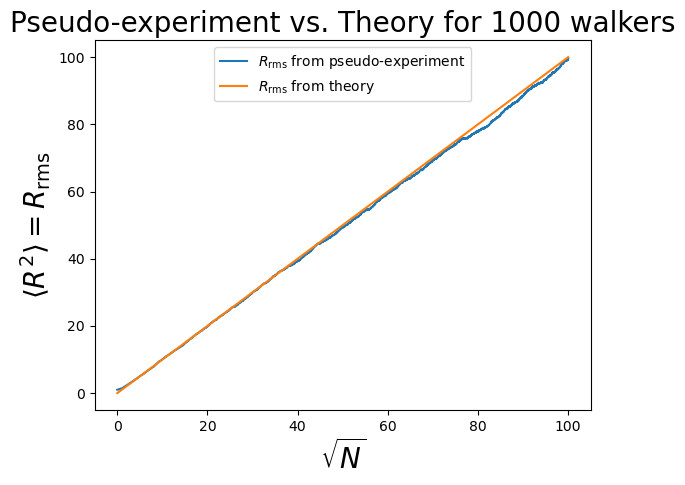

In [19]:
import matplotlib.pyplot as plt
import math

# first, create a list for square root(N):
sqrtN = [math.sqrt(x) for x in range(N)]

# the theoretical expectation is R_rms = sqrt(N) * r_rms (where r_rms = step in this case):
R_rms_theory = [math.sqrt(y)*step for y in range(N)]

# setup the axis:
fig,ax = plt.subplots(1,1)

# set the labels and titles:
ax.set_xlabel(r'$\sqrt{N}$', fontsize=20) # set the x label
ax.set_ylabel(r'$\left<R^2\right> = R_\mathrm{rms}$', fontsize=20) # set the y label. Note that the 'r' is necessary to remove the need for double slashes. You can use LaTeX! 
ax.set_title('Pseudo-experiment vs. Theory for ' + str(n) + ' walkers' , fontsize=20) # set the title 

# plot the pseudo-experiment result
ax.plot(sqrtN, R_rms_list, ls='-', label=r'$R_\mathrm{rms}$ from pseudo-experiment')

# plot the theoretical expectation
ax.plot(sqrtN, R_rms_theory, ls='-', label=r'$R_\mathrm{rms}$ from theory')

# construct the legend:
ax.legend(loc='upper center')  # Add a legend

plt.show() # show the plot here



E.g. for ```n = 1000``` walkers and ```N = 10000``` steps, the agreement is excellent! 

## NumPy Random Numbers

In scientific computing, it’s good practice to use NumPy’s modern random-number interface, ```numpy.random.default_rng(seed)```. It creates a random number generator object that you explicitly pass around and call for draws (uniforms, normals, integers, etc.), which makes your code reproducible (via the seed), more modular (no hidden global state), and often faster when generating large arrays. A typical pattern is: create ```rng = np.random.default_rng(12345)``` once at the top of your simulation, then use methods like ```rng.random(...)```, ```rng.normal(...)```, or ```rng.integers(...)``` whenever you need randomness. 

Here is an example:

In [15]:
import numpy as np

# set the seed
rng = np.random.default_rng(12345)

u = rng.random()                  # one uniform in [0, 1)
u_vec = rng.random(5)             # 5 uniforms
x = rng.normal(loc=0.0, scale=1.0, size=1000)   # 1000 Gaussians with mu=0 and sigma=1.0
k = rng.integers(low=0, high=10, size=20)       # 20 ints in {0,...,9}

print(u)
print(u_vec)
print(k[:10])

0.22733602246716966
[0.31675834 0.79736546 0.67625467 0.39110955 0.33281393]
[2 5 9 3 9 5 2 0 4 3]
